## 데이콘 비트코인 가격 예측 - Neural Prophet pilot

### library install & import, data load

In [1]:
# import library
from datetime import timedelta, datetime
from copy import deepcopy
import datetime
import argparse
import random
import warnings


import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

from tqdm import tqdm
import matplotlib.pyplot as plt

# model
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed



%matplotlib inline
plt.rc('font', family='NanumGothic')
warnings.filterwarnings(action = "ignore")

# read file
train_x_df = pd.read_csv("./data/train_x_df.csv")
train_y_df = pd.read_csv("./data/train_y_df.csv")
print("Reading Complete!")


Reading Complete!


### data preprocess functions

In [19]:
def df2d_to_array3d(df_2d):

    ''' 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수 '''

    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    
    return array_3d

def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()    
    plt.show()
    
def coin_index_export(input_array, coin_num):

    ''' 코인별 인덱스를 뽑아 list형식으로 만들어주는 함수 '''
    
    index = []
    sample_id_len = input_array.shape[0]
    coin_num_col = 0 

    for sample_id in range(sample_id_len):
        if input_array[sample_id, 0, coin_num_col] == coin_num:
            #print(sample_id)
            index.append(sample_id)
    
    return index


def prophet_preprocessor(x_series):
    
    # start time initialization
    start_time = '2021-01-01 00:00:00'
    start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

    # datafram 만들기
    x_df = pd.DataFrame()
    # 분당 시간 데이터 시리즈 입력
    x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
    # 가격 데이터 시리즈 입력
    x_df['y'] = x_series.tolist()

    return x_df

### modeling

In [31]:
def train(x_series, y_series, args):
    
    x_df = prophet_preprocessor(x_series)
    
    model = NeuralProphet(
                          n_changepoints = args.n_changepoints,
                          d_hidden = args.d_hidden,
                          changepoints_range = args.changepoints_range,
                          num_hidden_layers = args.num_hidden_layers,

                          learning_rate = 0.1, epochs=40, batch_size = 32, loss_func="Huber",
                          seasonality_mode = 'multiplicative',
                          yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False,
                          normalize='off' # Type of normalization ('minmax', 'standardize', 'soft', 'off')
                         )
    
    model.add_seasonality(name='first_seasonality', period=1/24, fourier_order= 7 ) 
    model.add_seasonality(name='second_seasonality', period=1/12, fourier_order= 15)

    metrics = model.fit(x_df, freq="min")

    future = model.make_future_dataframe(x_df, periods=120)
    forecast = model.predict(future)
    
    y_pred = forecast.yhat1.values[-120:]
    error = mean_squared_error(y_series, y_pred)
    plotting(y_series, y_pred, args.sample_id)

    return error*10E5


def plotting(y_true, y_pred, sample_id):
    plt.plot(np.arange(1380, 1380+120), y_true, label = 'True series')
    plt.plot(np.arange(1380, 1380+120), y_pred, label = 'Prediction series')
    plt.title(f'{sample_id}샘플 예측 플랏')
    plt.legend()
    
    file_path = f'./experiment/neural_prophet_{sample_id}.png'
    plt.savefig(file_path, dpi = 300)
    plt.show()


In [32]:

def experiment(train_x_array, train_y_array, args):
    
    sample_indices = coin_index_export(input_array = train_x_array, coin_num= args.coin_num)
    sample_id_indices = random.sample(sample_indices, 5)
    print(sample_id_indices)

    total_mse = 0.0
    for sample_id in sample_id_indices:
        args.sample_id = sample_id
        
        x_series = train_x_array[sample_id, :, args.data_col_idx] 
        y_series = train_y_array[sample_id, :, args.data_col_idx]
        
#         plot_series(x_series, y_series)
        temp_mse = train(x_series, y_series, args)
        total_mse += temp_mse 
    print('\nTotal MSE Error------------------------------------', total_mse, end='\n')



### setting

In [33]:
# ====== Random Seed Initialization ====== #
seed = 7

np.random.seed(seed)
set_random_seed(seed)
random.seed(seed)
parser = argparse.ArgumentParser()
args = parser.parse_args("")


# ====== Data Loading ====== #
args.data_col_idx = 1 # 1 open, 2 high
args.coin_num = 9

# ====== Model Capacity ===== #
args.n_changepoints = 20
args.changepoints_range = 0.95
args.num_hidden_layers = 1
args.d_hidden = 30


train_x_array = df2d_to_array3d(train_x_df.copy())
train_y_array = df2d_to_array3d(train_y_df.copy())

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

[7014, 1181, 4718, 7579, 733]


Epoch[40/40]: 100%|██████████████████████| 40/40 [00:04<00:00,  9.36it/s, SmoothL1Loss=4.94e-5, MAE=0.00501, RegLoss=0]


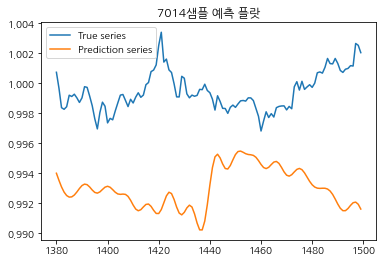

Epoch[40/40]: 100%|██████████████████████| 40/40 [00:04<00:00,  9.62it/s, SmoothL1Loss=1.98e-5, MAE=0.00343, RegLoss=0]


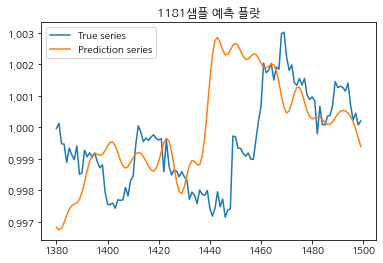

Epoch[40/40]: 100%|████████████████████████| 40/40 [00:03<00:00, 10.82it/s, SmoothL1Loss=7.9e-5, MAE=0.0092, RegLoss=0]


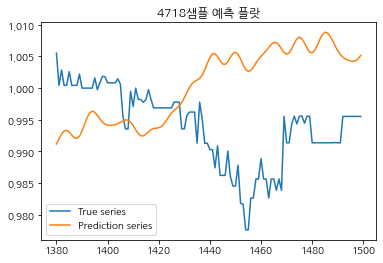

Epoch[40/40]: 100%|██████████████████████| 40/40 [00:03<00:00, 11.63it/s, SmoothL1Loss=4.66e-5, MAE=0.00652, RegLoss=0]


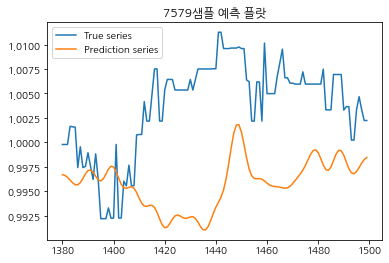

Epoch[40/40]: 100%|███████████████████████| 40/40 [00:04<00:00,  9.47it/s, SmoothL1Loss=8.2e-6, MAE=0.00318, RegLoss=0]


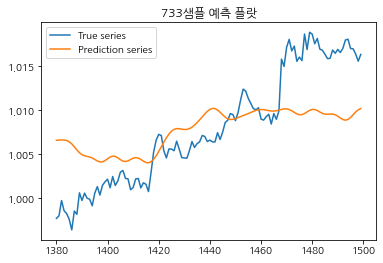


Total MSE Error------------------------------------ 323.49238818897646


In [35]:
experiment(train_x_array, train_y_array, deepcopy(args))